In [1]:
%matplotlib inline

import collections
import glob
import json
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
seaborn.set_style("whitegrid")

In [2]:
base_dirpath = "/home/wulfebw/experiments/procgen_031"

In [3]:
def flatten_string_key_dict(d):
    result = dict()
    for k, v in d.items():
        if isinstance(v, dict):
            v = flatten_string_key_dict(v)
            for kk, vv in v.items():
                flat_key = f"{k}_{kk}"
                if isinstance(vv, list):
                    vv = "_".join(str(vvv) for vvv in vv)
                result[flat_key] = vv
        else:
            result[k] = v
    return result

def load_params_as_dataframe(filepath):
    with open(filepath, "r") as infile:
        params = json.load(infile)
        params = flatten_string_key_dict(params)
        return pd.DataFrame(params, index=[0])

def extract_relevant_info_from_row(row):
    info = dict()
    info["episode_reward_mean"] = row["episode_reward_mean"]
    if "evaluation" in row:
        info["evaluation_episode_reward_mean"] = row["evaluation"]["episode_reward_mean"]
    return info

def load_results_as_dataframe(filepath):
    data = []
    with open(filepath, "r") as infile:
        for row in infile:
            parsed = json.loads(row)
            parsed = extract_relevant_info_from_row(parsed)
            data.append(parsed)
    return pd.DataFrame(data)

class Run:
    def __init__(self, params, results):
        self.params = params
        self.results = results
        
    def as_row(self):
        """Returns a representation / summary of this run that can be used as a single row."""
        row = self.params.copy()
        if "evaluation_episode_reward_mean" in self.results:
            row["evaluation_episode_reward_mean"] = list(self.results["evaluation_episode_reward_mean"].dropna())[-1]
        return row
        
    def __len__(self):
        return len(self.results)
    
    @property
    def env(self):
        return self.params["env_config_env_name"].values[0]
    
    @classmethod
    def from_filepaths(cls, params_filepath, results_filepath, min_num_iter=300):
        assert os.path.exists(params_filepath)
        assert os.path.exists(results_filepath)
        params = load_params_as_dataframe(params_filepath)
        results = load_results_as_dataframe(results_filepath)
        if len(results) < min_num_iter:
            return None
        return cls(params, results)

In [4]:
test_filepath = "/home/wulfebw/experiments/procgen_031/bossfight/itr_0_bossfight_drac_transforms_random_translate_terminal_intrinsic_reward/custom_DataAugmentingPPOTrainer_custom_procgen_env_wrapper_1_2020-10-03_10-38-147zl9vvhn"
params_filepath = os.path.join(test_filepath, "params.json")
result_filepath = os.path.join(test_filepath, "result.json")

In [5]:
r = Run.from_filepaths(params_filepath, result_filepath)

In [6]:
r.params.keys()

Index(['batch_mode', 'callbacks', 'clip_actions', 'clip_param', 'clip_rewards',
       'compress_observations', 'entropy_coeff', 'env',
       'env_config_center_agent', 'env_config_distribution_mode',
       'env_config_env_name', 'env_config_env_wrapper_options_frame_diff',
       'env_config_env_wrapper_options_frame_diff_options_dt',
       'env_config_env_wrapper_options_frame_diff_options_grayscale',
       'env_config_env_wrapper_options_frame_stack',
       'env_config_env_wrapper_options_frame_stack_options_k',
       'env_config_env_wrapper_options_frame_stack_phase_correlation',
       'env_config_env_wrapper_options_frame_stack_phase_correlation_options_phase_correlate',
       'env_config_env_wrapper_options_grayscale',
       'env_config_env_wrapper_options_mixed_grayscale_color',
       'env_config_env_wrapper_options_mixed_grayscale_color_options_num_prev_frames',
       'env_config_env_wrapper_options_normalize_reward',
       'env_config_num_levels', 'env_config_paint

In [7]:
runs = []
for root, dirs, filenames in os.walk(base_dirpath):
    if "result.json" in filenames and "params.json" in filenames:
        params_filepath = os.path.join(root, "params.json")
        results_filepath = os.path.join(root, "result.json")
        run = Run.from_filepaths(params_filepath, results_filepath)
        if run is not None:
            runs.append(run)

In [8]:
ENV_NAMES = list(set(r.env for r in runs))
print(ENV_NAMES)

['jumper', 'chaser', 'ninja', 'leaper', 'heist', 'bossfight', 'climber', 'plunder', 'caveflyer', 'fruitbot', 'dodgeball', 'maze', 'coinrun', 'starpilot', 'bigfish', 'miner']


In [14]:
def plot_run(run, ax, key):
    y = run.results[key]
    x = range(len(y))
    ax.plot(x, y, alpha=0.8)
    ax.set_title(run.env)

def plot_runs(runs, key="episode_reward_mean"):
    fig, axs = plt.subplots(4, 4, figsize=(16, 16))
    for run in runs:
        ax_index = ENV_NAMES.index(run.env)
        ax_row = ax_index // 4
        ax_col = ax_index % 4
        plot_run(run, axs[ax_row, ax_col], key)

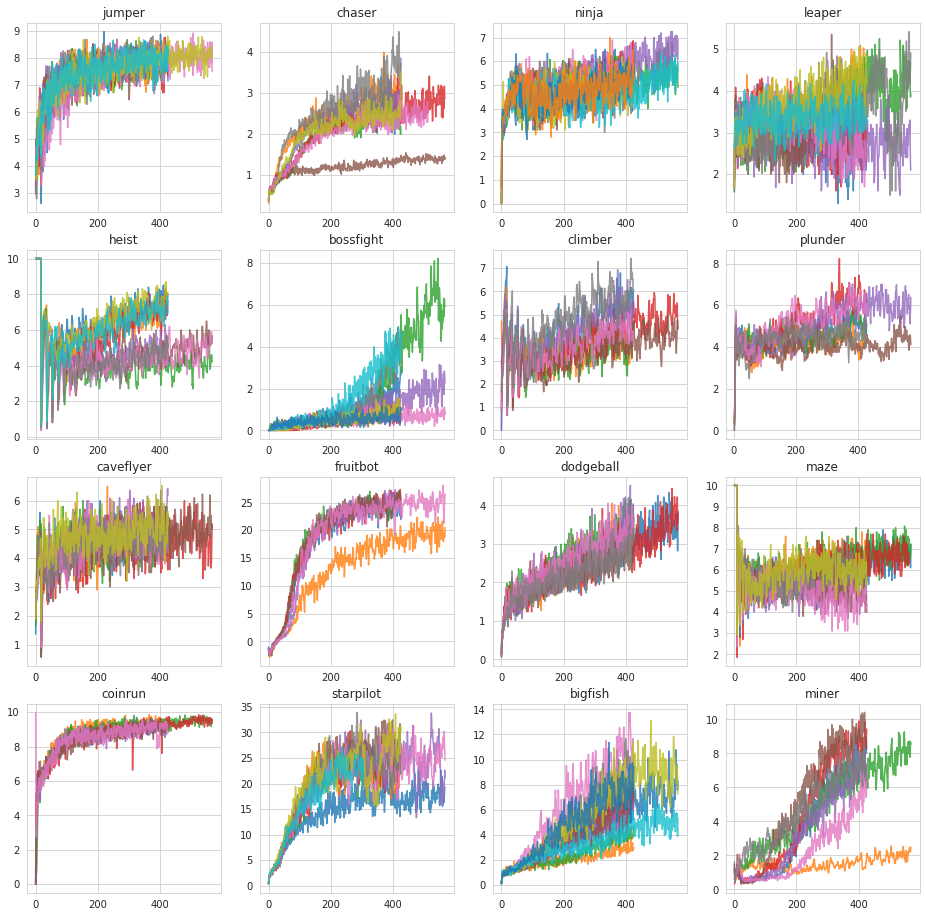

In [15]:
plot_runs(runs)

In [16]:
class AggregateRun:
    def __init__(self, runs, field, value):
        self.runs = runs
        self.field = field
        self.value = value
        
    def for_env(self, env):
        return AggregateRun([r for r in self.runs if r.env == env], self.field, self.value)
            
    def __repr__(self):
        return f"{self.field}: {self.value}"

def aggregate_runs(runs, aggregation_key):
    aggregate_runs = collections.defaultdict(list)
    for run in runs:
        if aggregation_key not in run.params:
            aggregate_runs["missing"].append(run)
        else:
            key = tuple(str(v) for v in run.params[aggregation_key].values)
            aggregate_runs[key].append(run)
    aggregate_runs = [AggregateRun(v, aggregation_key, k) for (k, v) in aggregate_runs.items()]
    return aggregate_runs

In [17]:
aggregation_key = "model_custom_options_intrinsic_reward_options_use_noop_penalty"
agg_runs = aggregate_runs(runs, aggregation_key)

In [18]:
print(agg_runs)

[model_custom_options_intrinsic_reward_options_use_noop_penalty: ('True',), model_custom_options_intrinsic_reward_options_use_noop_penalty: missing]


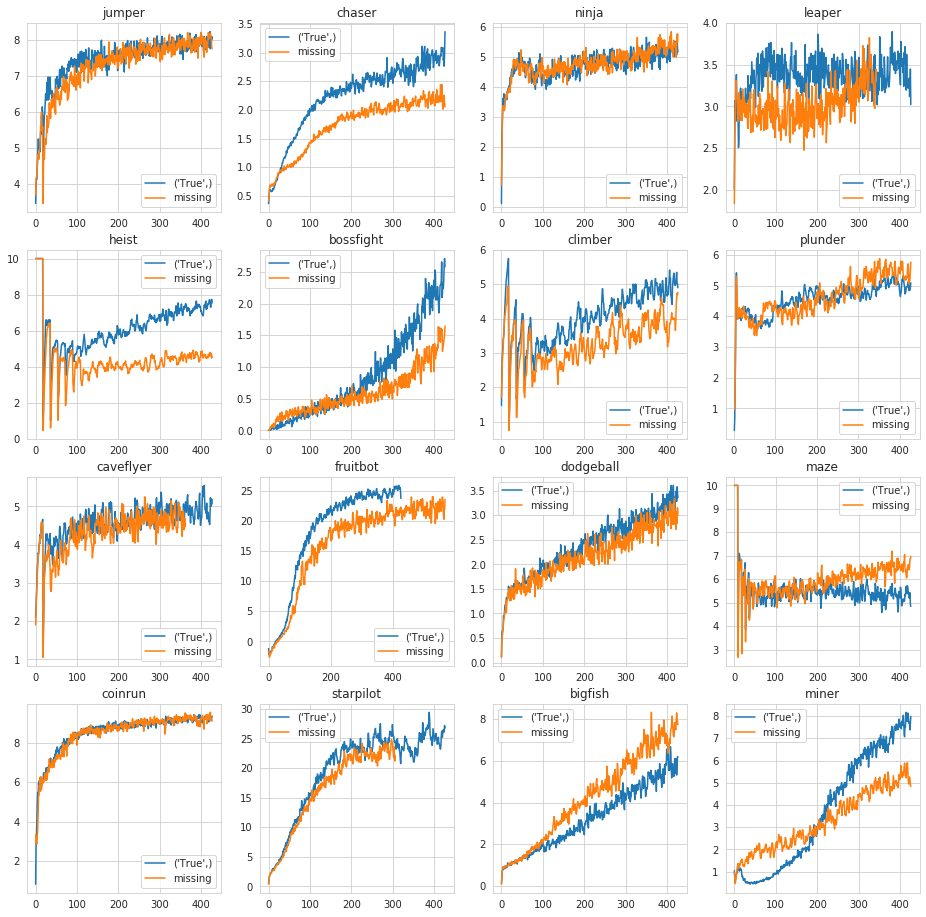

In [25]:
def plot_agg_run(agg_run, ax, key):
    values = [r.results[key] for r in agg_run.runs]
    mean = np.mean(values, axis=0)
    # std = np.std(values, axis=0) / np.sqrt(len(values))
    x = range(len(mean))
    ax.plot(x, mean, label=f"{agg_run.value}")
    ax.set_title(agg_run.runs[0].env)

fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for i, env_name in enumerate(ENV_NAMES):
    ax_row = i // 4
    ax_col = i % 4
    ax = axs[ax_row, ax_col]
    for agg_run in agg_runs:
        plot_agg_run(
            agg_run.for_env(env_name), 
            ax,
            key="episode_reward_mean"
        )
    ax.legend()